In [6]:
  !git clone https://github.com/azimsurani/track-data

Cloning into 'track-data'...
remote: Enumerating objects: 17653, done.
remote: Counting objects: 100% (17653/17653), done.
remote: Compressing objects: 100% (17653/17653), done.
remote: Total 17653 (delta 0), reused 17653 (delta 0), pack-reused 0
Receiving objects: 100% (17653/17653), 223.23 MiB | 32.58 MiB/s, done.
Checking out files: 100% (17650/17650), done.


In [7]:
!ls track-data/

driving_log.csv  IMG


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import adam_v2
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [9]:
datadir = 'track-data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  \
0  C:\Users\azim2\Desktop\Training Data\IMG\center_2022_04_02_23_15_41_235.jpg   
1  C:\Users\azim2\Desktop\Training Data\IMG\center_2022_04_02_23_15_41_336.jpg   
2  C:\Users\azim2\Desktop\Training Data\IMG\center_2022_04_02_23_15_41_438.jpg   
3  C:\Users\azim2\Desktop\Training Data\IMG\center_2022_04_02_23_15_41_540.jpg   
4  C:\Users\azim2\Desktop\Training Data\IMG\center_2022_04_02_23_15_41_642.jpg   

                                                                         left  \
0   C:\Users\azim2\Desktop\Training Data\IMG\left_2022_04_02_23_15_41_235.jpg   
1   C:\Users\azim2\Desktop\Training Data\IMG\left_2022_04_02_23_15_41_336.jpg   
2   C:\Users\azim2\Desktop\Training Data\IMG\left_2022_04_02_23_15_41_438.jpg   
3   C:\Users\azim2\Desktop\Training Data\IMG\left_2022_04_02_23_15_41_540.jpg   
4   C:\Users\azim2\Desktop\Training Data\IMG\left_2022_04_02_23_15_41_642.jpg   

                                                                         right  \
0   C:\Users\azim2\Desktop\Training Data\IMG\right_2022_04_02_23_15_41_235.jpg   
1   C:\Users\azim2\Desktop\Training Data\IMG\right_2022_04_02_23_15_41_336.jpg   
2   C:\Users\azim2\Desktop\Training Data\IMG\right_2022_04_02_23_15_41_438.jpg   
3   C:\Users\azim2\Desktop\Training Data\IMG\right_2022_04_02_23_15_41_540.jpg   
4   C:\Users\azim2\Desktop\Training Data\IMG\right_2022_04_02_23_15_41_642.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000080  
1  0.0       0.0       0.0      0.000078  
2  0.0       0.0       0.0      0.000078  
3  0.0       0.0       0.0      0.000078  
4  0.0       0.0       0.0      0.000079

In [10]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2022_04_02_23_15_41_235.jpg  left_2022_04_02_23_15_41_235.jpg   
1  center_2022_04_02_23_15_41_336.jpg  left_2022_04_02_23_15_41_336.jpg   
2  center_2022_04_02_23_15_41_438.jpg  left_2022_04_02_23_15_41_438.jpg   
3  center_2022_04_02_23_15_41_540.jpg  left_2022_04_02_23_15_41_540.jpg   
4  center_2022_04_02_23_15_41_642.jpg  left_2022_04_02_23_15_41_642.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2022_04_02_23_15_41_235.jpg  0.0       0.0       0.0      0.000080  
1  right_2022_04_02_23_15_41_336.jpg  0.0       0.0       0.0      0.000078  
2  right_2022_04_02_23_15_41_438.jpg  0.0       0.0       0.0      0.000078  
3  right_2022_04_02_23_15_41_540.jpg  0.0       0.0       0.0      0.000078  
4  right_2022_04_02_23_15_41_642.jpg  0.0       0.0       0.0      0.000079

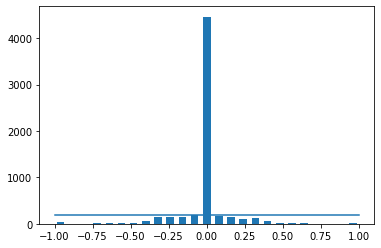

In [11]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 5883
removed: 4264
remaining: 1619


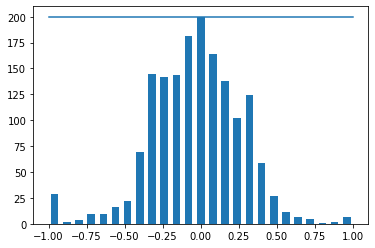

In [12]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [13]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  print(len(df))
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
print(len(steerings))

center      center_2022_04_02_23_15_46_121.jpg
left        left_2022_04_02_23_15_46_121.jpg  
right       right_2022_04_02_23_15_46_121.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0.0                               
speed       0.000078                          
Name: 48, dtype: object
1619
4857


Training Samples: 3885
Valid Samples: 972


Text(0.5, 1.0, 'Validation set')

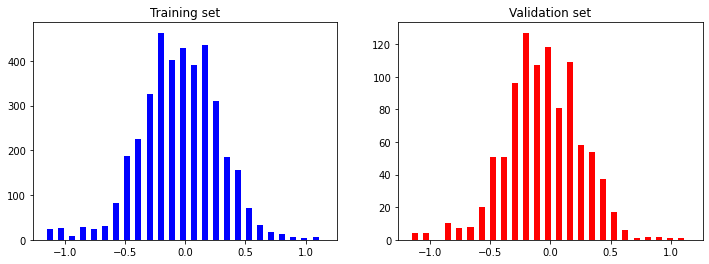

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

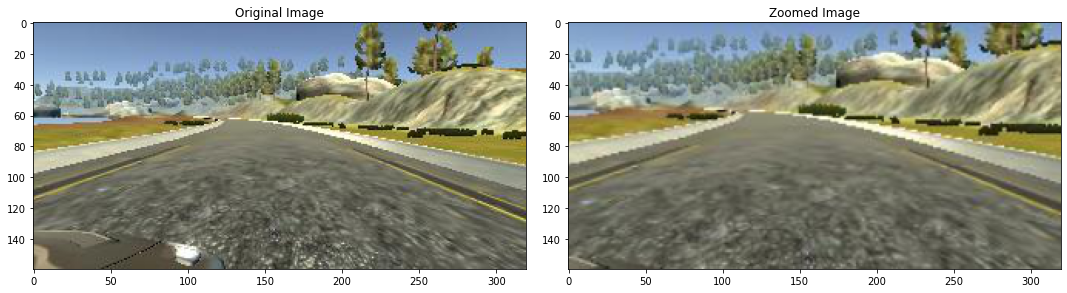

In [15]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Brightness altered image ')

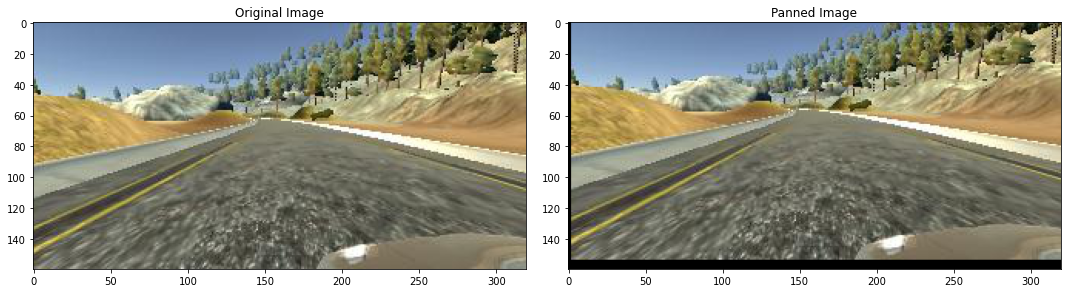

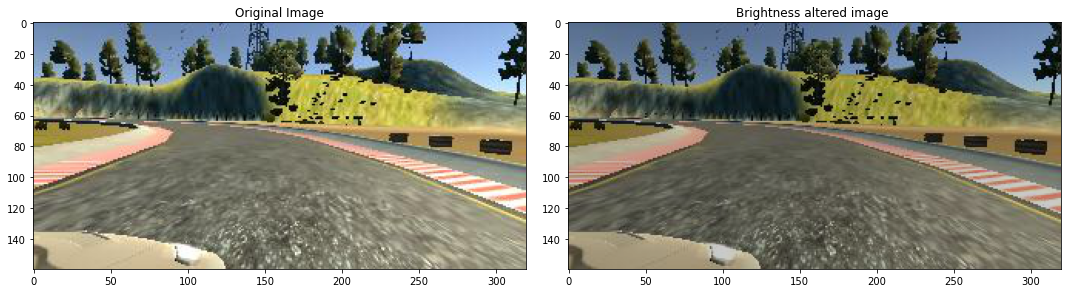

In [16]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.2994342')

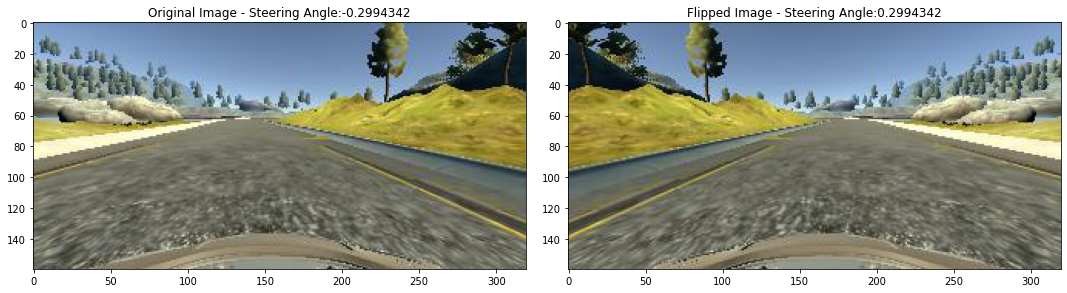

In [17]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [18]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

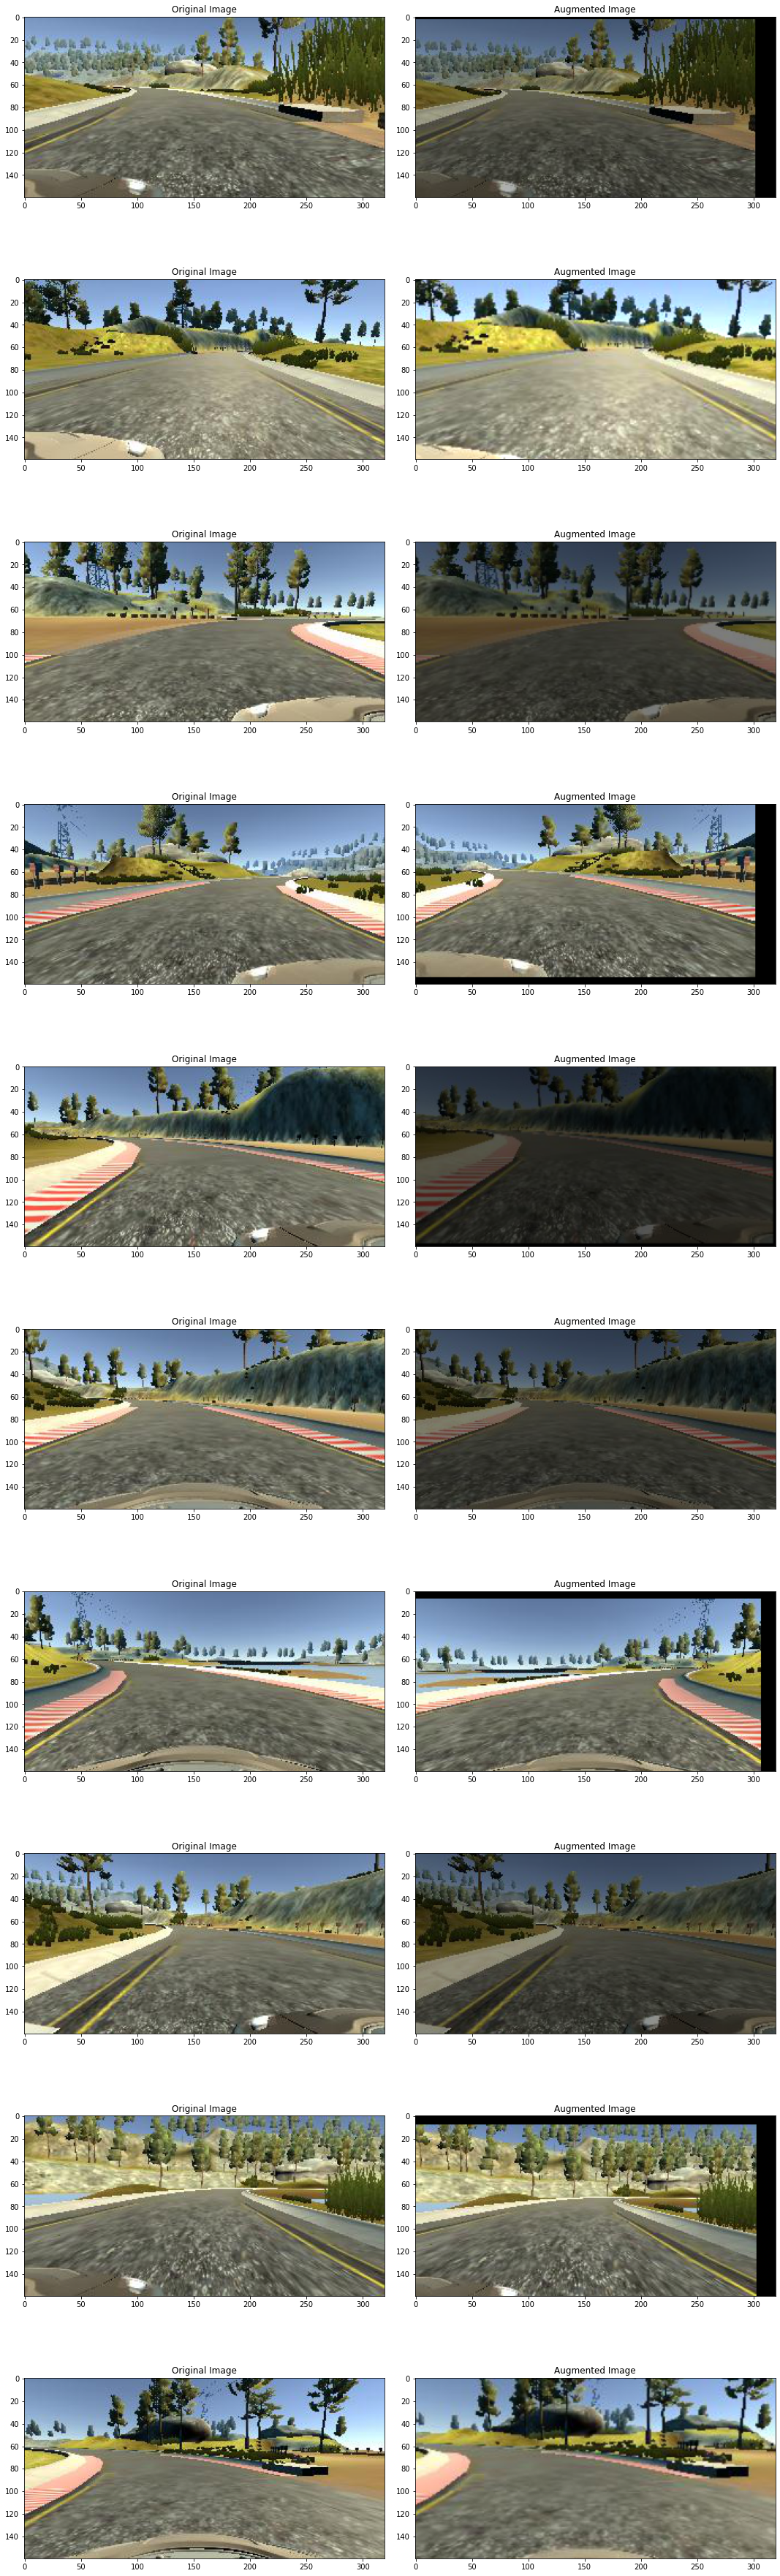

In [19]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [20]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

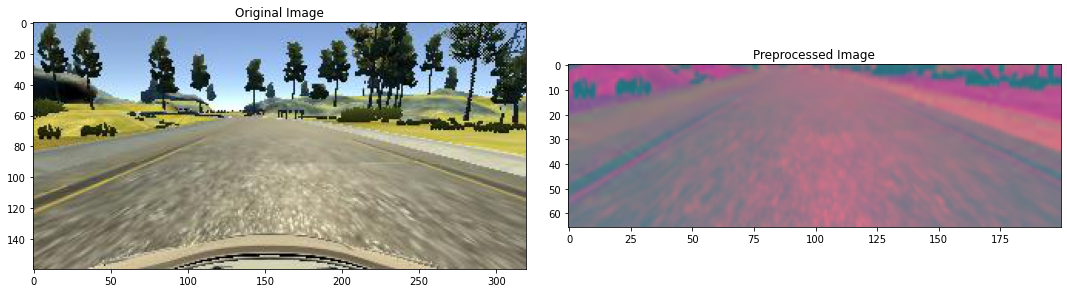

In [21]:
image = image_paths[random.randint(0,len(image_paths))]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [22]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  


Text(0.5, 1.0, 'Validation Image')

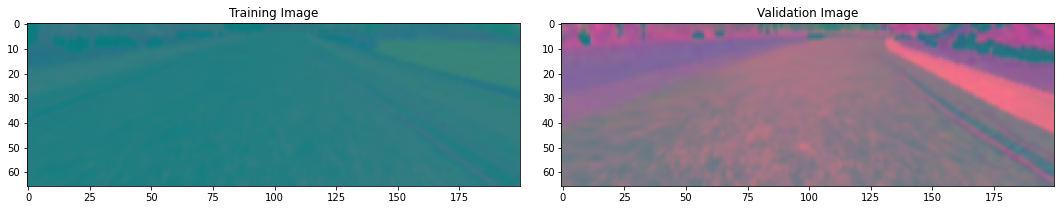

In [23]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [24]:
def nvidia_model():
 
  model = Sequential()
 
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
 
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2)))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2)))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(Conv2D(64, kernel_size=(3,3)))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(Conv2D(64, kernel_size=(3,3)))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(Dropout(0.5))
 
 
  model.add(Flatten())
  model.add(Dense(100))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(Dropout(0.5))
 
 
  model.add(Dense(50))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(Dense(10))
  model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
  model.add(Dense(1))
 
 
  optimizer= adam_v2.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
 
  return model

In [25]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 47, 36)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 5, 22, 48)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 3, 20, 64)        

In [26]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 221s 703ms/step - loss: 0.0949 - val_loss: 0.0575
Epoch 2/10
300/300 [==============================] - 209s 698ms/step - loss: 0.0686 - val_loss: 0.0457
Epoch 3/10
300/300 [==============================] - 218s 729ms/step - loss: 0.0624 - val_loss: 0.0405
Epoch 4/10
300/300 [==============================] - 211s 705ms/step - loss: 0.0556 - val_loss: 0.0387
Epoch 5/10
300/300 [==============================] - 208s 696ms/step - loss: 0.0491 - val_loss: 0.0336
Epoch 6/10
300/300 [==============================] - 206s 689ms/step - loss: 0.0465 - val_loss: 0.0338
Epoch 7/10
300/300 [==============================] - 209s 698ms/step - loss: 0.0466 - val_loss: 0.0363
Epoch 8/10
300/300 [==============================] - 210s 701ms/step - loss: 0.0440 - val_loss: 0.0319
Epoch 9/10
300/300 [==============================] - 215s 719ms/step - loss: 0.0423 - val_loss: 0.0306
Epoch 10/10
300/300 [==============================] - 210s 702m

Text(0.5, 0, 'Epoch')

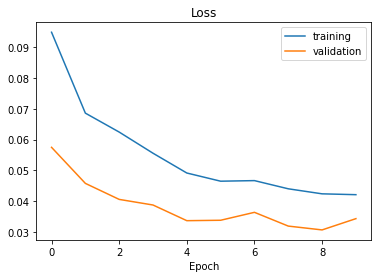

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [30]:
model.save('model-lrelu.h5')

In [31]:
from google.colab import files
files.download('model-lrelu.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>